In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt

# A Better 🐍 PyTree 🌲 interface!

So ✨ `Equinox` ✨ is an awesome package that gives us the ability to build object-oriented software in `Jax` 🤯, however it is a low-level package, designed around generality and flexibilty, which can make building a simple API for user-facing software a challenege. The less that astronomers have to learn about 😱 `lambda` functions 😱, the better! To help with this, I've constrcuted a series of PyTree helper methods, designed to give a simpler and more intuitive interface with these obejcts, as well as a few other methods designed to simplify interfacing with some of the most valueable packages used in conjunction with our software, namely `Optax` and `Numpyro`.

If you are new to `Jax`, note that all object are *immutable*, which simply means that you can NOT do in-place updates. ie any time we update some parameter, we return a new version of that object, this will become clear throughout the tutorial!

---
# The `Base` Class

In order to make this functionality accessible to all PyTree objects, the `Base` class hold all this functionality, from which all created classes can inherit from. This also means that other software can just import this low-level class if they also want to have this functionality! 

In order to have this simpler interface there are two simple object types that drive this:

 1. The `path` object
 2. The `path_dict` object

The `path` object is a nested set of lists/tuples that can contain either strings or integers. They are used to specify the path within the PyTree to the `leaf` that we want to interact with! Do note that the `path` object is not a specific or unique data-type, just a helpful way of thinking about leaf referencing.

The `path_dict` is a dictionary that is designed to further simplify repeatedly interfacing with highly structured classes. This allows us to reference objects/leaves via a simple key, rather than the full path every time. We will define this at later in the script to show both ways of using these methods

---

## The Overview

There are three main types of methods added to this base class: Accessors, Updaters, and Interfaces

Accessors:
>
> - .get_leaf(path, path_dict=dict)
>
> - .get_leaves(paths, path_dict=dict)

Updaters:
>
> - .update_leaves(paths, values, path_dict=dict)
>
> - .apply_to_leaves(paths, fns, path_dict=dict)

Interfaces:
> Equinox Methods:
>
> > .get_filter_spec(paths, path_dict=dict)

> Optax Methods:
> 
> > .get_param_spec(paths, groups, path_dict=dict, get_filter_spec=bool)
> 
> > .get_optimiser(paths, optimisers, path_dict=dict, get_filter_spec=bool)

> Numpyro Methods:
> 
> > .update_and_model(model_fn, paths, values, path_dict=dict, *args, **kwargs)

We will go over these in detail shortly.

---

## How to use them

Lets start by creating a minimal example class that will allow us to show all of the desired functionality. Here we create an nested pytree class that models a super-gaussian. Note the structure is arbitrary, this is why is has a 'useless_list' attribute, its just to show how to access specific nested items within a PyTree/list/tuple.

In [3]:
class Variances(Base):
    var_x: float
    var_y: float
    useless_list: list

    def __init__(self, var_x, var_y, useless_list):
        self.var_x = var_x
        self.var_y = var_y
        self.useless_list = useless_list


class SuperGaussian(Base):
    variances: object
    power: dict

    def __init__(self, variances, power):
        self.variances = variances
        self.power = power

    def model(self, flatten=False):
        xs = np.linspace(-50, 50, 100)
        XX, YY = np.meshgrid(xs, xs)

        x = (XX / self.variances.var_x) ** 2
        y = (YY / self.variances.var_y) ** 2

        g = np.exp(-((x + y) ** self.power))

        if flatten:
            return g.flatten()
        else:
            return g

SuperGaussian(
  variances=Variances(var_x=10, var_y=10, useless_list=[-1, -2]),
  power=1
)


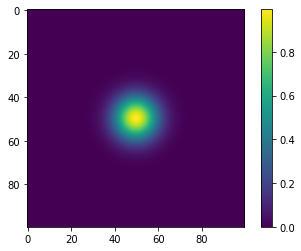

In [4]:
# Create an instance of the SuperGaussian object
var_x, var_y = 10, 10
power = 1
useless_list = [-1, -2]

# Create the object
variances = Variances(var_x, var_y, useless_list)
pytree = SuperGaussian(variances, 1)

# Examine the object
print(pytree)

# Examine the output gaussian
gauss = pytree.model()

# Plot
plt.imshow(gauss)
plt.colorbar()
plt.show()

---
---

## Accessor Methods

Accessors:
>
> - .get_leaf(path, path_dict=dict)
>
> - .get_leaves(paths, path_dict=dict)

These two methods simply take in a single path or list of paths and return the corresponding attributes!

Lets define some paths and check that everything works!

In [5]:
# Define paths
path1 = ["power"]
path2 = ["variances", "var_x"]
path3 = ["variances", "useless_list", 1]
paths = [path1, path2, path3]

# Access objects using .get_leaf()
print(pytree.get_leaf(path1))
print(pytree.get_leaf(path2))
print(pytree.get_leaf(path3))

# Access objects using .get_leaves()
print(pytree.get_leaves(paths))

1
10
-2
[1, 10, -2]


Great! Simple enough, now lets move on the the Updater method

---
---

## Updater Methods

> - .update_leaves(paths, values, path_dict=dict)

This returns an updated version of the pytree, with the values places at the corresponding path.

> - .apply_to_leaves(paths, fns, path_dict=dict)

This returns an updated version of the pytree, with the values specified by the paths having the correspoinding function applied.


Note that these methods performs no checks and do not preserve data type. If you pass in the wrong data-type you will very likely break your code. For example if you pass in a list instead of a jax array no errors will be thrown untill some other part of the downstream code expect a jax array in its place. Be careful!

In [6]:
# .update_leaves()

# Define paths
path1 = ["power"]
path2 = ["variances", "var_x"]
path3 = ["variances", "useless_list", 1]
paths = [path1, path2, path3]

value = [-10]
values = [1e2, 1e3, 1e4]

print(pytree.update_leaves(path1, value))
print(pytree.update_leaves(paths, values))

SuperGaussian(
  variances=Variances(var_x=10, var_y=10, useless_list=[-1, -2]),
  power=-10
)
SuperGaussian(
  variances=Variances(var_x=1000.0, var_y=10, useless_list=[-1, 10000.0]),
  power=100.0
)


In [7]:
# .apply_to_leaves()

# Define paths
path1 = ["power"]
path2 = ["variances", "var_x"]
path3 = ["variances", "useless_list", 1]
paths = [path1, path2, path3]

fn = [lambda x: 5 * x]
fns = [lambda x: -x, lambda x: 1e2 * x, lambda x: x + 5]

print(pytree.apply_to_leaves(path1, fn))
print(pytree.apply_to_leaves(paths, fns))

SuperGaussian(
  variances=Variances(var_x=10, var_y=10, useless_list=[-1, -2]),
  power=5
)
SuperGaussian(
  variances=Variances(var_x=1000.0, var_y=10, useless_list=[-1, 3]),
  power=-1
)


---
### Nesting

So now is a good time to introduce the nesting concept. Lets say we wanted to update multiple parameters with the *same* value. We can achieve this simply by nesting our paths within each other! Each value will be applied to the corresponding list of paths!

This also works with the `.apply_to_leaves()` method

In [8]:
# Define paths
path1 = ["power"]
path2 = ["variances", "var_x"]
path3 = ["variances", "useless_list", 1]

# Nested paths strucutre
paths = [[path1, path2], path3]
print(pytree.update_leaves(paths, [-1e2, 1e4]))

SuperGaussian(
  variances=Variances(var_x=-100.0, var_y=10, useless_list=[-1, 10000.0]),
  power=-100.0
)


---

## Path dictionary

The path dictionary as mentioned earlier is a way to further simplify our interface with PyTrees. By definintely the paths we care about inside the dictionary we can use simple keys to refer to those leaves! This is expecially useful for highly nested structures or leaves that we want to refer to many times. Note that we don't have to define *every* path the *every* leaf inside the dictionary, we can use a mix of paths and keys to refer to obejcts. We can also use the nesting concept with keys/paths interchangably.

Note: The path_dict keys MUST NOT match any of the parameter names within any of the classes or sub-classes, or the methods will break. ie each key must be uniquely named from all parameters!

In [9]:
path_dict = {
    "pow": ["power"],
    "xvar": ["variances", "var_x"],
    "yvar": ["variances", "var_y"],
}

print(pytree.get_leaf(["pow"], path_dict=path_dict))
print(pytree.get_leaves(["pow", "xvar"], path_dict=path_dict))

1
[1, 10]


The methods have also been built to be flexible in the way that you pass in the path objects.

 1. A single list of keys are understood referencing multiple leaves, rather than a single path
 2. Nested lists of keys work identically to nested paths
 3. Single keys do not *need* to be wrapped in lists
 
Lets see those in action, using each of these edge cases to access the same parameters

In [10]:
# 1
print(pytree.get_leaves(["yvar", "pow"], path_dict=path_dict))

# 2
print(pytree.get_leaves([["variances", "var_y"], ["power"]], path_dict=path_dict))

# 3
print(pytree.get_leaves([["variances", "var_y"], "power"], path_dict=path_dict))

[10, 1]
[10, 1]
[10, 1]


---
---

## Interfacing Functions!


### Equinox filter function interface!

> .get_filter_spec(paths, path_dict=dict)

This takes in a list of paths and returns a filter_spec ready to be passed straight into any Equinox filter function!

Lets see how we can use this to optimise a model using Equniox along

In [11]:
import equinox as eqx
from tqdm.notebook import tqdm

In [12]:
# Define paths to the variables we care about, and new values
paths = ["xvar", "yvar", "pow"]
new_values = [np.array(15.0), np.array(5.0), np.array(1.5)]

# Get a new pytree to optimise
model_pytree = pytree.update_leaves(paths, new_values, path_dict=path_dict)

# Generate a filter_spec to pass to equinox filter functions
filter_spec = model_pytree.get_filter_spec(paths, path_dict=path_dict)

In [13]:
# Define the loss function
@eqx.filter_jit()
@eqx.filter_value_and_grad(arg=filter_spec)
def loss_fn(model, data):
    return np.sum((model.model() - data) ** 2)

In [14]:
# Make some fake data and evaluate loss
fake_data = pytree.model()
loss, grads = loss_fn(model_pytree, fake_data)
print(loss, grads.variances.var_x, grads.variances.var_y, grads.power)
print(grads)

48.419075 3.3206873 -13.782466 15.091436
SuperGaussian(
  variances=Variances(var_x=f32[], var_y=f32[], useless_list=[None, None]),
  power=f32[]
)


In [15]:
# Define a basic step function
get_step = lambda grads, lr: jax.tree_map(lambda leaf: -lr * leaf, grads)

# Optimise the model
for i in tqdm(range(500)):
    loss, grads = loss_fn(model_pytree, fake_data)
    model_pytree = eqx.apply_updates(model_pytree, get_step(grads, 1e-2))

# Print the final values to check that eveything works
(model_pytree.variances.var_x, model_pytree.variances.var_y, model_pytree.power)

  0%|          | 0/500 [00:00<?, ?it/s]

(DeviceArray(10.002723, dtype=float32, weak_type=True),
 DeviceArray(9.997313, dtype=float32, weak_type=True),
 DeviceArray(1.0000018, dtype=float32, weak_type=True))

Awesome! As we can see we were able to recover out true parameters!

---

### Optax param_spec interface!

So next we want to be able to actually optmise a model using optax, so we need to define a param_spec!

> .get_param_spec(path, groups, path_dict=dict, get_filter_spec=bool)

This function lets us generate a param_spec in order to group parameters and apply optimiser to them. We could pass in the filter_spec from before, or we could use the inbuilt functionality that returns the correct filter_spec for the given param_spec.

Lets group the two variances together, and the power to its own group, and see how we go

In [16]:
import optax

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [17]:
# Define paths to the variables we care about, and new values
paths = ["xvar", "yvar", "pow"]
new_values = [np.array(15.0), np.array(5.0), np.array(1.5)]

# Get a new pytree to update
model_pytree = pytree.update_leaves(paths, new_values, path_dict=path_dict)

In [18]:
# Define the parameter groups for the param spec
# Use the nested path functionality to group the variances together!
paths = [["xvar", "yvar"], "pow"]
groups = ["var", "pow"]
param_spec, filter_spec = model_pytree.get_param_spec(
    paths, groups, get_filter_spec=True, path_dict=path_dict
)

print(param_spec)
print(filter_spec)

SuperGaussian(
  variances=Variances(var_x='var', var_y='var', useless_list=['null', 'null']),
  power='pow'
)
SuperGaussian(
  variances=Variances(var_x=True, var_y=True, useless_list=[False, False]),
  power=True
)


In [19]:
#  Define Learning rates
var_lr = 1e0
pow_lr = 1e-1

# Use the generated param spec to map optimisers
# Be sure to match the values defined in 'groups'!
optim = optax.multi_transform(
    {"null": optax.adam(0.0), "var": optax.adam(var_lr), "pow": optax.adam(pow_lr)},
    param_spec,
)

# Initialise & optimise a for single epoch
opt_state = optim.init(model_pytree)
for i in tqdm(range(100)):
    loss, grads = loss_fn(model_pytree, fake_data)
    updates, opt_state = optim.update(grads, opt_state)
    model_pytree = eqx.apply_updates(model_pytree, updates)

# Print the final values to check that eveything works
(model_pytree.variances.var_x, model_pytree.variances.var_y, model_pytree.power)

  0%|          | 0/100 [00:00<?, ?it/s]

(DeviceArray(10.0163355, dtype=float32),
 DeviceArray(9.992455, dtype=float32),
 DeviceArray(0.9996456, dtype=float32))

Great it all works!

---

### Optax optimiser interface!

> .get_pytree_optimiser(paths, optimisers, get_filter_spec=bool)

So in most use-cases, we can avoid the need to interact with the optax.multi_transform function all together, allowing us to *only* define the optimisers we wish to apply to each parameter and group. Lets have a look how we can do that!

In [20]:
# Define paths to the variables we care about, and new values
paths = ["xvar", "yvar", "pow"]
new_values = [np.array(15.0), np.array(5.0), np.array(1.5)]

# Get a new pytree to update
model_pytree = pytree.update_leaves(paths, new_values, path_dict=path_dict)

In [21]:
# Define paths and corresponsing optimisers
paths = [["xvar", "yvar"], "pow"]
optimisers = [optax.adam(1e-1), optax.adam(1e-2)]

# Get optimiser and filter_spec
optim, fs = pytree.get_optimiser(
    paths, optimisers, get_filter_spec=True, path_dict=path_dict
)

# Initialise & Optimise
opt_state = optim.init(model_pytree)

for i in tqdm(range(100)):
    loss, grads = loss_fn(model_pytree, fake_data)
    updates, opt_state = optim.update(grads, opt_state)
    model_pytree = eqx.apply_updates(model_pytree, updates)

# Print the final values to check that eveything works
(model_pytree.variances.var_x, model_pytree.variances.var_y, model_pytree.power)

  0%|          | 0/100 [00:00<?, ?it/s]

(DeviceArray(9.98567, dtype=float32),
 DeviceArray(9.955453, dtype=float32),
 DeviceArray(0.98905396, dtype=float32))

How easy was that!

---

### Numpyro interface!

The last package we want to be able to interact with easily is Numpyro, so we can run MCMCs!

> .update_and_model(model_fn, paths, values, path_dict=dict, *args, **kwargs)

So for this method the paths, values and path_dict should all be familiar by now. The difference here is that we also must specify with function is the one used th generate our model. This is done using a string to reference the method. Similarly if we need to pass extra agruments into the modelling function we can do that with the *args and **kwargs. I will show to to pass in key word arguments here!

For those who haven't used Numpyro, you need to define a modelling function with all of the parameters you wish to sample. This minimal example should give you a good idea of what to do, but for a more in-depth exploration of its functionality and behaviour, check out [this great tutorial](https://dfm.io/posts/intro-to-numpyro/)

In [22]:
import numpyro as npy
import numpyro.distributions as dist
import jax.random as jr
import chainconsumer as cc

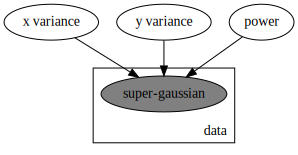

In [23]:
def modelling_fn(data, model, path_dict=None):
    """ """
    # Define parameter sampling
    var_x = npy.sample("x variance", dist.Uniform(0, 100))
    var_y = npy.sample("y variance", dist.Uniform(0, 100))
    power = npy.sample("power", dist.Uniform(0, 10))

    # Define paths and values
    paths = ["xvar", "yvar", "pow"]
    values = [var_x, var_y, power]

    with npy.plate("data", len(data)):
        poisson_model = dist.Normal(
            model.update_and_model(
                "model", paths, values, path_dict=path_dict, flatten=True
            )
        )

        return npy.sample("super-gaussian", poisson_model, obs=data)


npy.render_model(
    modelling_fn, model_args=(fake_data.flatten(), model_pytree, path_dict)
)

In [24]:
# Using the model above, we can now sample from the posterior distribution
# using the No U-Turn Sampler (NUTS).
sampler = npy.infer.MCMC(
    npy.infer.NUTS(modelling_fn),
    num_warmup=2000,
    num_samples=2000,
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), fake_data.flatten(), model_pytree, path_dict)

sample: 100%|███████████████████████████| 4000/4000 [00:07<00:00, 526.05it/s, 3 steps of size 6.80e-01. acc. prob=0.92]


CPU times: user 8.62 s, sys: 94.6 ms, total: 8.72 s
Wall time: 8.69 s


In [25]:
sampler.print_summary()
values_out = sampler.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       power      1.06      0.21      1.04      0.74      1.37   1442.49      1.00
  x variance     10.03      1.04      9.98      8.33     11.72   1542.57      1.00
  y variance     10.02      0.99     10.01      8.35     11.59   1548.37      1.00

Number of divergences: 0


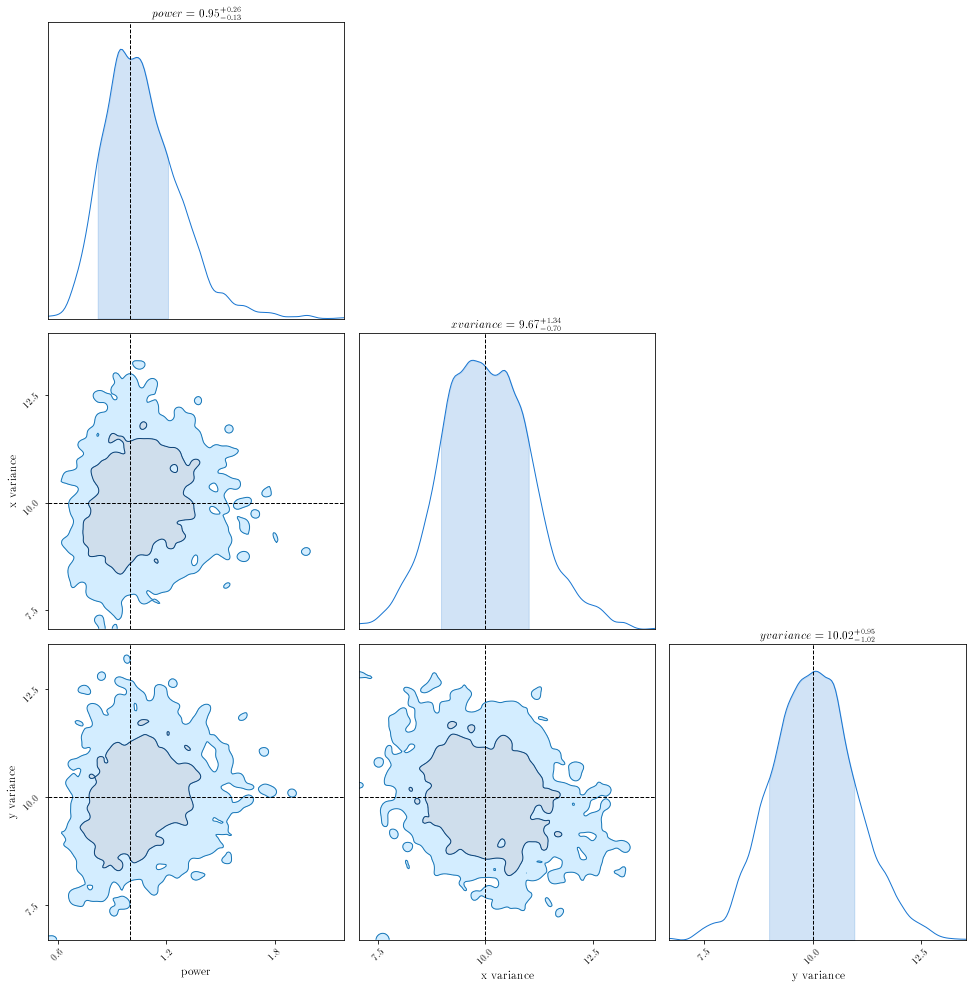

In [26]:
chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(
    serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1.0, max_ticks=3
)
fig = chain.plotter.plot(truth={"power": 1, "x variance": 10, "y variance": 10})
fig.set_size_inches((15, 15));